## Importing the Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

## Importing the Cleaned and Basic Feature Engineered Data

In [66]:
train_data = pd.read_pickle('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/advanced_fe_train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/advanced_fe_test.pkl')

In [4]:
with open("/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/features_having_covariate_shift.pkl", 'rb') as handle:
  drop_cols = pickle.load(handle)

In [67]:
train_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,...,uid1_id_02_ct,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud
0,2987000,86400,68.5,4,3417,500,42,38,1,166,...,0,0,1,1,1,1,1,1,1,0
1,2987001,86401,29.0,4,7922,303,42,2,1,173,...,1,1,6,6,4,4,1,1,0,0
2,2987002,86469,59.0,4,9383,389,42,58,2,178,...,0,0,1,1,2,2,2,2,1,0
3,2987003,86499,50.0,4,6991,466,42,14,2,282,...,2,2,2,2,114,114,115,115,0,0
4,2987004,86506,50.0,1,9262,413,42,2,1,241,...,1,1,1,1,1,1,1,1,0,0


In [68]:
train_data.isFraud.value_counts()

0    569875
1     20663
Name: isFraud, dtype: int64

In [7]:
569875-20663

549212

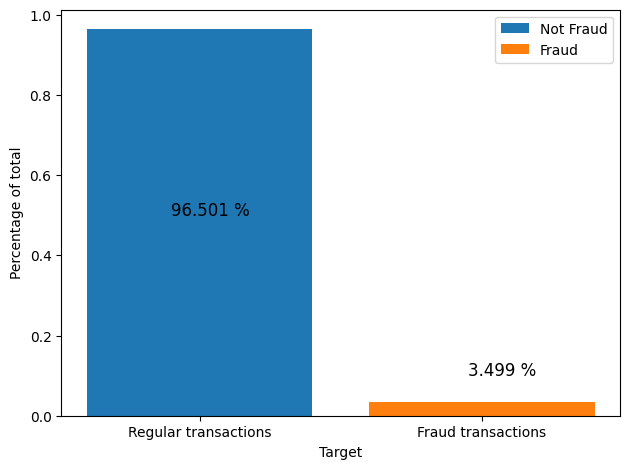

In [8]:


ratio_ones = train_data.isFraud.mean()
ratio_zeros = (len(train_data) - train_data.isFraud.sum())/len(train_data)

plt.bar('Regular transactions', height=ratio_zeros, label='Not Fraud')
plt.bar('Fraud transactions', height=ratio_ones, label='Fraud')
plt.xlabel("Target")
plt.ylabel('Percentage of total')
plt.text(-0.10, 0.5, "{0:.3f} %".format(ratio_zeros*100), fontsize=12)
plt.text(0.95, 0.1, "{0:.3f} %".format(ratio_ones*100), fontsize=12)
plt.legend()
plt.tight_layout()



>  This shows that the data is highly imabalanced



In [9]:
train_data.TransactionAmt.describe()

count    590538.000000
mean        134.919470
std         231.891289
min           0.251000
25%          43.321000
50%          68.758000
75%         125.000000
max        6450.970000
Name: TransactionAmt, dtype: float64

In [10]:
transaction_amount_threshold = 100
amount_flag = ((train_data.TransactionAmt > transaction_amount_threshold).astype(int))
amount_flag.value_counts()

0    368619
1    221919
Name: TransactionAmt, dtype: int64

In [70]:
train_data.isnull().sum().sum()

38129644

In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590538 entries, 0 to 590539
Columns: 309 entries, TransactionID to isFraud
dtypes: float64(213), int64(95), int8(1)
memory usage: 1.4 GB


In [71]:
train_data = train_data.fillna(train_data.mean())

In [72]:

X = train_data.drop(['isFraud']+drop_cols, axis=1)
y = train_data['isFraud']

In [16]:
!pip install gunicorn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.4 MB/s eta 0:00:00


## Implementation a conditional Generative Adversarial Network (cGAN) using TensorFlow's Keras API.

Loss Function : Binary Cross Entropy<br>
Label Smoothing is Applied<br>
Optimizer : Adam (learning_rate 0.0002)<br>


In [17]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
np.random.seed(34)

'''
  This is cGAN which encapsulates the Generator and Discriminator class

'''
class cGAN():
    def __init__(self, out_shape):
        self.latent_dim = 304
        self.out_shape = out_shape
        self.num_classes = 2
        self.clip_value = 0.01
        optimizer = Adam(0.0002, 0.5)

        #optimizer = RMSprop(lr=0.00005)

        # build discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # build generator
        self.generator = self.build_generator()

        # generating new data samples
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        self.discriminator.trainable = False

        # passing gen samples through disc.
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])
        self.combined.summary()


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  Train Discriminator with 8 sample from postivite class and rest with negative class
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            # Condition on labels
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            if (epoch+1)%sample_interval==0:
                print (f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [18]:
cgans = cGAN(296)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               152064    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0

In [75]:
X_gans = X
X_gans

,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid2_DT_M_ct,uid1_id_02_ct,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15
0,68.50,4,3417,500,42,38,1,166,65,19.000000,...,1,0,0,1,1,1,1,1,1,1
1,29.00,4,7922,303,42,2,1,173,65,118.502948,...,6,1,1,6,6,4,4,1,1,0
2,59.00,4,9383,389,42,58,2,178,65,287.000000,...,4,0,0,1,1,2,2,2,2,1
3,50.00,4,6991,466,42,14,2,282,65,118.502948,...,6,2,2,2,2,114,114,115,115,0
4,50.00,1,9262,413,42,2,1,241,65,118.502948,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.00,4,10855,500,42,108,2,132,65,48.000000,...,2,0,0,2,2,3,3,3,3,1
590536,39.50,4,390,124,42,106,2,78,65,118.502948,...,1,0,0,1,1,1,1,1,1,0
590537,30.95,4,1782,494,42,106,2,98,65,118.502948,...,6,12,12,8,8,59,59,64,64,0
590538,117.00,4,11847,380,42,106,2,219,65,3.000000,...,6,5,5,6,6,24,24,26,26,0


## Training the GAN

 Reshapes the target variable y into a column vector and identifies indices for positive and negative class samples. Then, it initializes a cGAN model (cgans) and trains it using the specified features (X_gans.values) and reshaped target values (y_train_gans). The training occurs over 4000 epochs, with batches comprising a mix of positive and negative class samples, aiming to generate synthetic samples conditioned on the input labels for the given data.

In [76]:
y_train_gans = y.values.reshape(-1,1)
pos_index = np.where(y_train_gans==1)[0]
neg_index = np.where(y_train_gans==0)[0]
cgans.train(X_gans.values, y_train_gans, pos_index, neg_index, epochs=4000)

1/1 [==============================] - 0s 17ms/step
49 [D loss: -4986832709632.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 17ms/step
99 [D loss: -5118660495360.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 16ms/step
149 [D loss: -6486686382080.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 16ms/step
199 [D loss: -6434914672640.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 16ms/step
249 [D loss: -7096491693056.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 16ms/step
299 [D loss: -6307058200576.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 16ms/step
349 [D loss: -7854508003328.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 15ms/step
399 [D loss: -6535475960832.0, acc.: 0.0] [G loss: [0.0, 1.0]]
1/1 [==============================] - 0s 16ms/step
449 [D loss: -6823629898752.0,

This generates synthetic samples (gen_samples) using the trained generator of the cGAN (cgans) by providing randomly generated noise and a constant label of "1" for each sample.

In [63]:
noise = np.random.normal(0, 1, (549212, 304))
sampled_labels = np.ones(549212).reshape(-1, 1)
gen_samples = cgans.generator.predict([noise, sampled_labels])
gen_samples.shape

17163/17163 [==============================] - 26s 2ms/step


(549212, 296)

In [22]:
gen_samples

array([[ 0.9922266 , -0.9500722 ,  0.99754494, ..., -0.9126438 ,
         0.97642857,  0.9866296 ],
       [ 0.9738012 , -0.9270662 ,  0.9960896 , ..., -0.8991761 ,
         0.96929824,  0.98484737],
       [ 0.9740021 , -0.9301102 ,  0.99725026, ..., -0.948569  ,
         0.9768255 ,  0.9904085 ],
       ...,
       [ 0.9840028 , -0.9303302 ,  0.99503857, ..., -0.9018773 ,
         0.9567319 ,  0.98203695],
       [ 0.96590704, -0.9314576 ,  0.994911  , ..., -0.9362853 ,
         0.97012836,  0.9887355 ],
       [ 0.99074185, -0.93364525,  0.9927965 , ..., -0.917     ,
         0.945855  ,  0.9847787 ]], dtype=float32)

In [23]:
data_class_fraud = train_data.loc[train_data['isFraud'] == 1]
data_class_fraud

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,...,uid1_id_02_ct,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud
203,2987203,89760,445.000,4,7107,482,42,108,1,116,...,0,0,2,2,4,4,4,4,1,1
240,2987240,90193,37.098,0,2976,3,73,33,1,332,...,136,136,101,101,28,28,44,44,0,1
243,2987243,90246,37.098,0,2976,3,73,33,1,332,...,136,136,101,101,28,28,44,44,0,1
245,2987245,90295,37.098,0,2976,3,73,33,1,332,...,136,136,101,101,28,28,44,44,0,1
288,2987288,90986,155.521,0,5662,444,73,108,1,332,...,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590361,3577361,15807368,1224.000,4,8327,352,42,108,2,67,...,0,0,1,1,8,8,7,7,1,1
590364,3577364,15807516,69.964,0,10273,307,73,106,2,332,...,915,915,514,514,64,64,255,255,1,1
590368,3577368,15807677,100.000,1,11007,298,42,42,1,151,...,1,1,1,1,1,1,1,1,0,1
590372,3577372,15807758,117.000,4,3513,10,42,108,1,132,...,0,0,2,2,1,1,1,1,0,1


## Concatenation the generated data with the main dataframe to oversample

In [24]:
data_fraud_gans= np.concatenate((data_class_fraud.drop(['isFraud']+drop_cols, axis=1),gen_samples), axis=0)

In [25]:
data_fraud_gans.shape

(569875, 296)

In [26]:
data_fraud_gans = np.concatenate((data_fraud_gans,np.ones((569875,1))),axis=1)
data_fraud_gans.shape

(569875, 297)

In [27]:
data_non_fraud = train_data.loc[train_data['isFraud'] == 0]

In [28]:
data_non_fraud = data_non_fraud.drop(['isFraud']+drop_cols, axis=1)
data_non_fraud.shape

(569875, 296)

In [29]:
data_non_fraud_gans = np.concatenate((data_non_fraud,np.zeros((569875,1))),axis=1)
data_non_fraud_gans.shape

(569875, 297)

In [30]:
data_gans= np.concatenate((data_fraud_gans,data_non_fraud_gans), axis=0)
data_gans.shape
type(data_gans)
np.random.shuffle(data_gans)
data_gans.shape

(1139750, 297)

In [31]:
data_gans = pd.DataFrame(data_gans)

In [32]:
data_gans.columns = data_non_fraud.columns.tolist()+['isFraud']

In [33]:
data_gans['isFraud'].value_counts()

1.0    569875
0.0    569875
Name: isFraud, dtype: int64

In [34]:
data_gans.columns

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1',
       ...
       'uid1_id_02_ct', 'uid2_id_02_ct', 'uid1_cents_ct', 'uid2_cents_ct',
       'uid1_V127_ct', 'uid2_V127_ct', 'uid1_V307_ct', 'uid2_V307_ct',
       'outsider15', 'isFraud'],
      dtype='object', length=297)

In [35]:
del data_fraud_gans, data_non_fraud_gans, data_non_fraud, data_class_fraud

In [36]:
X_train, X_cv, y_train, y_cv = train_test_split(data_gans.drop(columns=['isFraud']), data_gans['isFraud'], test_size=0.20, shuffle=False)

In [37]:
del data_gans

In [42]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Cross Validation Data Shape : {} \n".format(X_cv.shape))
print("*"*45)

*********************************************

 Train Data Shape : (911800, 296) 


 Cross Validation Data Shape : (227950, 296) 

*********************************************


In [43]:
def hyperparam_vs_auc(train_roc_auc, cv_roc_auc):

    '''
        Utility Function to plot the Training and Cross Validation ROC-AUC Values
        for different Hyperparameter.
    '''

    plt.plot(range(len(train_roc_auc)), train_roc_auc, label='Train AUC')
    plt.plot(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC')

    plt.scatter(range(len(train_roc_auc)), train_roc_auc, label='Train AUC points')
    plt.scatter(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC points')

    plt.xticks(range(len(train_roc_auc)))
    plt.legend()
    plt.xlabel("Hyperparameter Index")
    plt.ylabel("AUC")
    plt.title("\n Hyperparameter vs ROC-AUC \n")
    plt.grid()
    plt.show()

## Setting the Hyperparameters range to tune the Model

In [44]:
# Hyperparameters

learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6,0.8,1]
colsample_bytree = [0.6,0.8,1]

## Hyperparameter tuning to find the best parameter of XGBoost model

In [ ]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

In [40]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

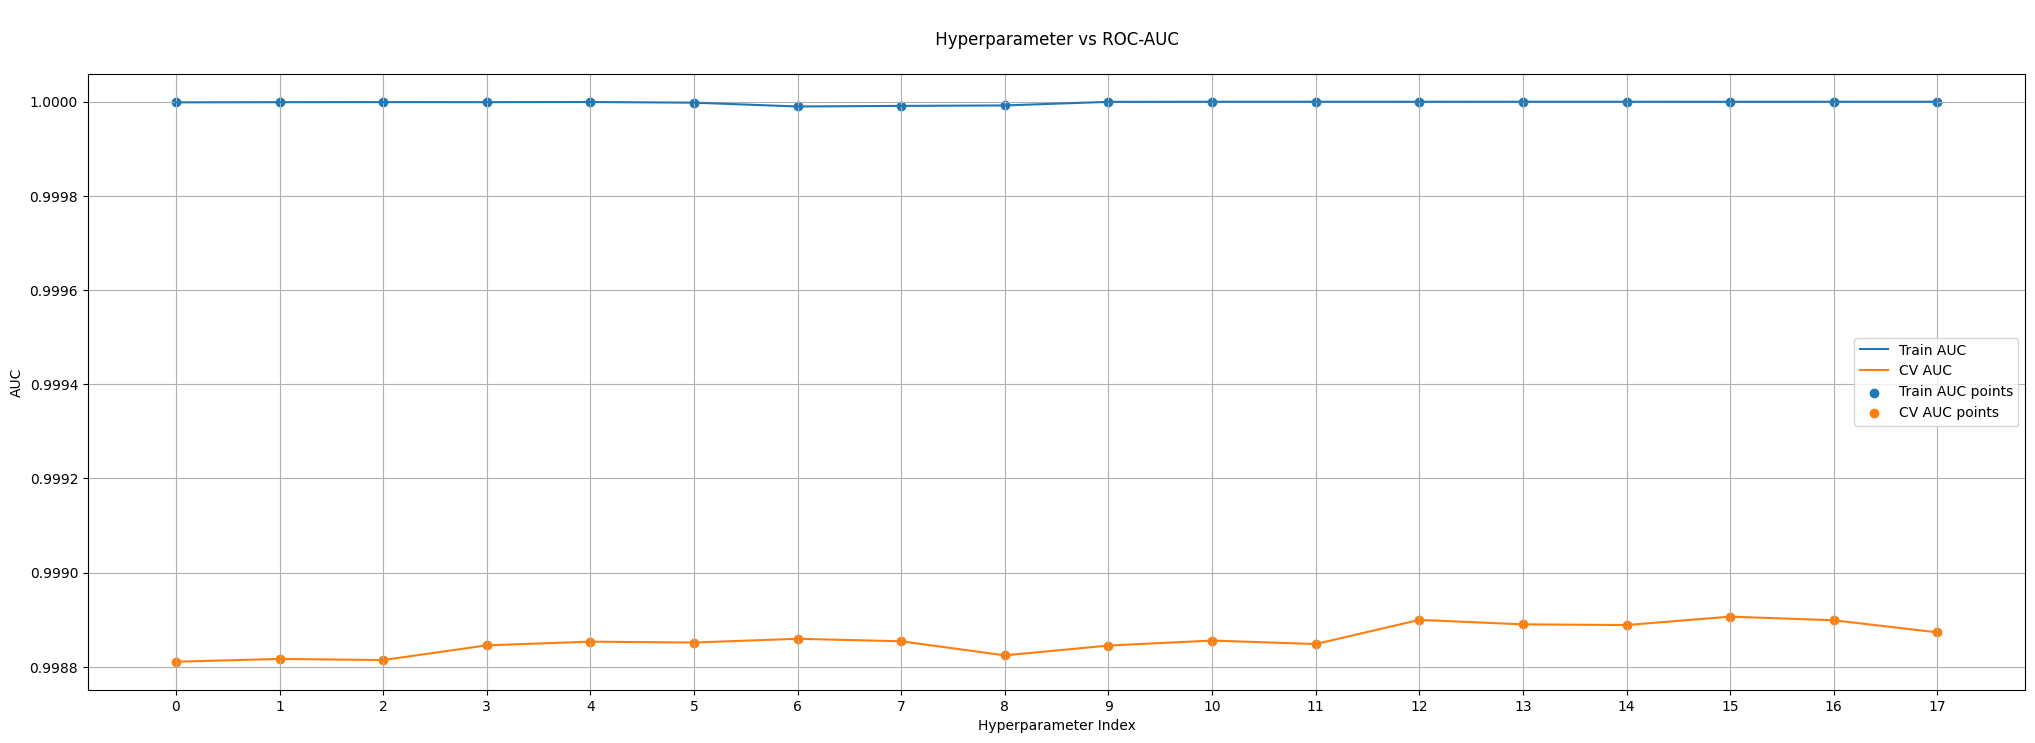

In [41]:
plt.figure(figsize=(25,8))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

Above visual represents how Cross Validation AUC changing while Hyperparameter Tuning

In [42]:
best_params = list(results.keys())[3]

In [43]:
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 8 subsample : 0.8 colsample_bytree : 0.6 


## Defining the utility functions

In [45]:
def tpr_fpr_threshold_auc(Y, proba):

    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''

    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)

    return (fpr, tpr, threshold, roc_auc)

In [46]:
def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''

    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [47]:
def best_threshold(threshold,tpr,fpr):

    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''

    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):

    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [48]:
def draw_confusion_matrix(Y, predicted):

    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [49]:
def predict_and_save(prediction, name):

    '''
        Utility Function to save the test data predictions locally.
    '''

    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

## Final XGB implementation on the oversampled data

  * The fit method is called to train the classifier on the training data
(X_train, y_train).
  * The training progress is evaluated on a validation set (eval_set=[(X_cv, y_cv)]) to monitor performance.
  * Verbose output with training information is printed every 50 iterations (verbose=50).
  * Early stopping is implemented with a patience of 100 rounds (early_stopping_rounds=100), which halts training if the performance on the validation set does not improve for consecutive rounds.

In [50]:
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=8,
    colsample_bytree=0.6,
    learning_rate=0.02
)

results = clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.99338
[50]	validation_0-auc:0.99534
[100]	validation_0-auc:0.99579
[150]	validation_0-auc:0.99638
[200]	validation_0-auc:0.99684
[250]	validation_0-auc:0.99722
[300]	validation_0-auc:0.99753
[350]	validation_0-auc:0.99776
[400]	validation_0-auc:0.99792
[450]	validation_0-auc:0.99804
[500]	validation_0-auc:0.99815
[550]	validation_0-auc:0.99827
[600]	validation_0-auc:0.99836
[650]	validation_0-auc:0.99845
[700]	validation_0-auc:0.99852
[750]	validation_0-auc:0.99858
[800]	validation_0-auc:0.99864
[850]	validation_0-auc:0.99868
[900]	validation_0-auc:0.99873
[950]	validation_0-auc:0.99877
[1000]	validation_0-auc:0.99880
[1050]	validation_0-auc:0.99884
[1100]	validation_0-auc:0.99886
[1150]	validation_0-auc:0.99889
[1200]	validation_0-auc:0.99891
[1250]	validation_0-auc:0.99893
[1300]	validation_0-auc:0.99896
[1350]	validation_0-auc:0.99898
[1400]	validation_0-auc:0.99899
[1450]	validation_0-auc:0.99901
[1500]	validation_0-auc:0.99903
[1550]	validation_0-auc:0.99904

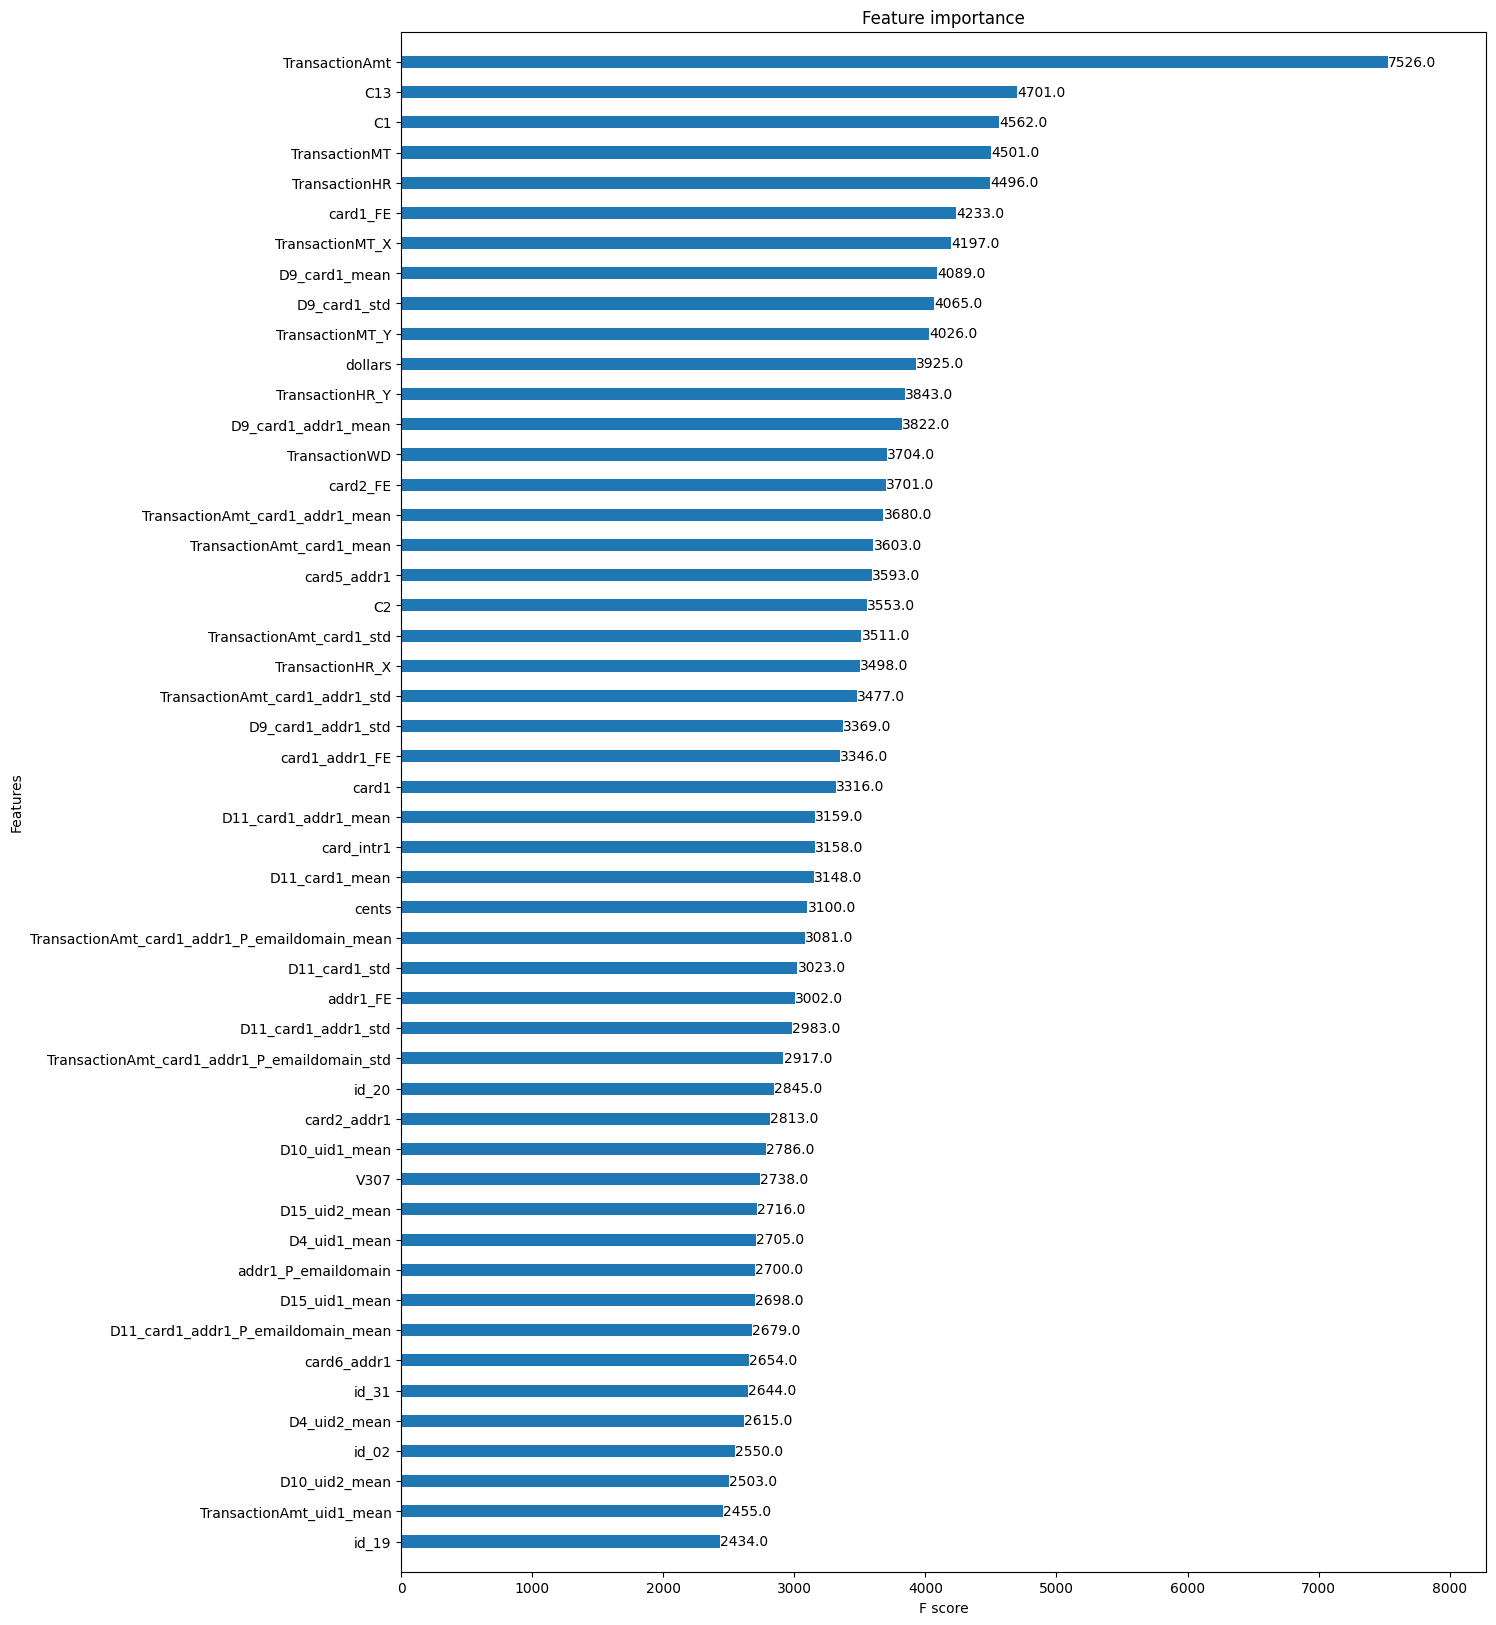

In [53]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [52]:
train_proba = clf.predict_proba(X_train)[:,1]
cv_proba = clf.predict_proba(X_cv)[:,1]

In [54]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

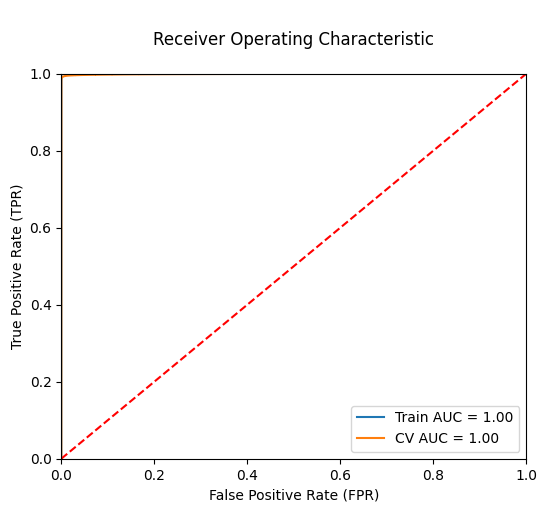

In [55]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

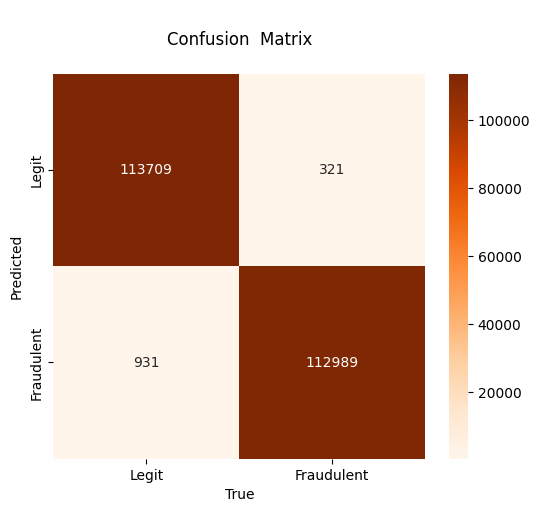

In [57]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)

In [59]:
del X_train, y_train

In [60]:
X_train = train_data.drop('isFraud', axis=1)
y_train = train_data['isFraud']

X_test = test_data
test_ids = test_data['TransactionID'].values

cols = [f for f in X_train if f not in drop_cols]

del train_data, test_data

The code implements cross-validated training of an XGBoost classifier using GroupKFold, printing information about the training progress, and accumulating the average predicted probabilities on the test set across all folds.

In [61]:

test_proba = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)

for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=3000,
        tree_method='gpu_hist',
        random_state=3,
        subsample=0.8,
        max_depth=8,
        colsample_bytree=0.6,
        learning_rate=0.02
    )

    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT],
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    test_proba += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits

Fold 0 withholding month 12
 rows of train = 453217 rows of holdout = 137321
[0]	validation_0-auc:0.78181
[100]	validation_0-auc:0.86223
[200]	validation_0-auc:0.88580
[300]	validation_0-auc:0.89576
[400]	validation_0-auc:0.89996
[500]	validation_0-auc:0.90368
[600]	validation_0-auc:0.90476
[700]	validation_0-auc:0.90578
[800]	validation_0-auc:0.90679
[900]	validation_0-auc:0.90721
[1000]	validation_0-auc:0.90781
[1100]	validation_0-auc:0.90803
[1200]	validation_0-auc:0.90779
[1298]	validation_0-auc:0.90770
Fold 1 withholding month 15
 rows of train = 488906 rows of holdout = 101632
[0]	validation_0-auc:0.79627
[100]	validation_0-auc:0.89125
[200]	validation_0-auc:0.91493
[300]	validation_0-auc:0.92617
[400]	validation_0-auc:0.93176
[500]	validation_0-auc:0.93537
[600]	validation_0-auc:0.93773
[700]	validation_0-auc:0.93929
[800]	validation_0-auc:0.94058
[900]	validation_0-auc:0.94130
[1000]	validation_0-auc:0.94192
[1100]	validation_0-auc:0.94220
[1200]	validation_0-auc:0.94222
[1300]

In [62]:
predict_and_save(test_proba, 'final_submission.csv')